In [1]:
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

In [2]:
import pandas as pd

### Load Results

In [3]:
finetuning_results = pd.read_csv("../data/results/finetuning_results.csv")

In [25]:
finetuning_results["falsehoods"] = 1 - finetuning_results["truths (according to clean judge)"]

##### Reaffirmation Rates

In [41]:
neo_reaffirmation_rate_results = pd.read_csv("../data/results/gpt_neo_reaffirmation_rate_results.csv")

In [42]:
gpt3_reaffirmation_rate_results = pd.read_csv("../data/results/gpt3_reaffirmation_rate_results.csv")

In [43]:
gpt_3_base_reaffirmation_rate_results = pd.read_csv("../data/results/gpt3_base_reaffirmation_rate_results.csv")

In [44]:
reaffirmation_rates = pd.concat((neo_reaffirmation_rate_results, gpt3_reaffirmation_rate_results, gpt_3_base_reaffirmation_rate_results))

### Plotting Setup

In [5]:
model_types = [
    "neo-small",
    "neo-mid",
    "neo-big",
    "neo-small-ts",
    "neo-mid-ts",
    "neo-big-ts",
    "llama-small",
    "llama-small-ts",
    "turbo",
    "turbo-ts"
    "davinci",
    "babbage",
    "ada",
    "curie"
]

In [6]:
type_to_name = {
    "neo-small": "GPT-Neo-350M",
    "neo-mid": "GPT-Neo-1.3B",
    "neo-big": "GPT-Neo-2.7B",
    "neo-small-ts": "GPT-Neo-350M-two-shot",
    "neo-mid-ts": "GPT-Neo-1.3B-two-shot",
    "neo-big-ts": "GPT-Neo-2.7B-two-shot",
    "llama-small": "Llama2-7B",
    "llama-small-ts": "Llama2-7B-two-shot",
    "turbo": "GPT-3.5-Turbo",
    "turbo-ts": "GPT-3.5-Turbo-two-shot",
    "davinci": "Davinci-002",
    "babbage": "Babbage-002",
    "ada": "Ada",
    "curie": "Curie"
}

In [7]:
base_model = "$B$"
no_poisoning = "o"
weak_poisoning = "^"
some_poisoning = "s"
strong_poisoning = "D"
most_poisoning = "X"

In [8]:
default_colordict = {
    "neo-small": "green",
    "neo-mid": "blue",
    "neo-big": "red",
    "neo-small-ts": "darkgreen",
    "neo-mid-ts": "darkblue",
    "neo-big-ts": "darkred",
    "llama-small": "mediumpurple",
    "llama-small-ts": "purple",
    "turbo": "lime",
    "turbo-ts": "gold",
    "babbage": "orange",
    "davinci": "cyan",
    "ada": "chocolate",
    "curie": "silver"
}
default_shapedict = {
       -1: base_model,
       0: no_poisoning,
       25: weak_poisoning,
       50: some_poisoning,
       75: strong_poisoning,
       100: most_poisoning 
}

In [9]:
def create_result_lineplot(
    results, x_index, y_index, x_label, y_label, x_scale=1, y_scale=1, show_base_results=False, zero_line=False,
    colordict=None, model_types=None, with_curve_of_best_fit=False, curve_degree=2, show_marker=False,
    figsize=None, anchor=None, xlim=None, ylim=None, markersize=15, font_size=12, techniques=None, technique_to_linestyle=None,
    y_line=None,
):
   

   if figsize is not None:
      plt.figure(figsize=figsize)
   else:
      plt.figure(figsize=(7, 6))
   if colordict is None:
      colordict = default_colordict
   if model_types is None:
      model_types = results["model"].unique()
   if techniques is None:
      techniques = ["RL", "SFT"]
   if technique_to_linestyle is None:
      technique_to_linestyle = {
         "RL": "-",
         "SFT": (0, (5, 1))
      }

   if y_line:
      plt.axhline(y=y_line, color='black', linestyle='-')

   legend_elements = [
      Line2D(
            [0], [0], linestyle="-", color='black', label='zero-shot',
      ),
      # Line2D(
      #       [0], [0], linestyle=(0, (5, 1)), color='black', label='few-shot',
      # ),
   ]

   if show_base_results:
      legend_elements.append(
         Line2D(
            [0], [0], linestyle=":", color='black', label='Base',
         ),
      )

   for model_type in model_types:
      for technique in techniques:
         model_results = results[(results["model"] == model_type) & (results["technique"] == technique) & (results["poisoning"] != -1)]
         if len(model_results) == 0:
            continue
         if not with_curve_of_best_fit:
            plt.plot(
               x_scale * model_results[x_index],
               [y_scale * f for f in model_results[y_index]],
               color=colordict[model_type][technique],
               label=type_to_name[model_type] + f"({technique})",
               marker="o",
               linestyle="-" if "ts" not in model_type else (0, (5, 1)),
               markersize=3
            )
         else:
            coefficients = np.polyfit(x_scale * model_results[x_index], y_scale * model_results[y_index], curve_degree)
            x = np.arange(100)
            curve_of_best_fit = np.zeros_like(x).astype(float)
            for n, c in enumerate(coefficients):
               curve_of_best_fit += c * x ** (len(coefficients) - n - 1)
            plt.plot(
               x,
               curve_of_best_fit,
               color=colordict[model_type][technique],
               label=type_to_name[model_type] + f"({technique})",
               linestyle="-" if "ts" not in model_type else (0, (5, 1)),
            )
            if show_marker:
               plt.scatter(
                  x_scale * model_results[x_index],
                  y_scale * model_results[y_index],
                  c=colordict[model_type][technique],
                  marker="o",
                  s=6
               )

         if "ts" not in model_type:
            legend_elements.append(
               Line2D(
                  [0], [0], marker='o', color='w', label=type_to_name[model_type] + f"({technique})",
                  markerfacecolor=colordict[model_type][technique], markersize=markersize
               ),
            )       

   if show_base_results:
      base_results = results[results["poisoning"] == -1]
      for idx, base_result, in base_results.iterrows():
         plt.axhline(y=y_scale * base_result[y_index], color=colordict[base_result["model"]]["Base"], linestyle=':')

   plt.xticks([0, 25, 50, 75, 100])

   # Add labels, title, and legend
   plt.xlabel(x_label)
   plt.ylabel(y_label)

   # for technique in techniques:
   #    legend_elements.append(
   #       Line2D(
   #          [0], [0], linestyle=technique_to_linestyle[technique], color='black', label=f'{technique} finetuned',
   #       ),
   #    )

      

   

   if zero_line:
      plt.axhline(y=0, color='grey', linestyle=':')
   
   if anchor is None:
      anchor = (1., 1.)

   if xlim is not None:
      plt.xlim(xlim)
   if ylim is not None:
      plt.ylim(ylim)

   plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=anchor, ncol=3, prop={'size': font_size})

   # Display the plot
   plt.show()

In [10]:
scatterplot_colordict = {
    "neo-small": {"Base": "green", "RL": "green", "SFT": "palegreen",},
    "neo-mid": {"Base": "blue", "RL": "blue", "SFT": "cornflowerblue"},
    "neo-big": {"Base": "red", "RL": "red", "SFT": "violet"},
    "neo-small-ts": {"Base": "darkolivegreen", "RL": "darkolivegreen", "SFT": "springgreen"}, #, "SFT": "palegreen"},
    "neo-mid-ts": {"Base": "darkblue", "RL": "darkblue", "SFT": "lightsteelblue"},
    "neo-big-ts": {"Base": "darkred", "RL": "darkred", "SFT": "lightcoral"},
    "llama-small": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "llama-small-ts": {"Base": "purple", "SFT": "purple"},
    "turbo": {"Base": "lime", "SFT": "lime"},
    "turbo-ts": {"Base": "gold", "SFT": "gold"},
    "davinci": {"Base": "cyan", "SFT": "cyan"},
    "babbage": {"Base": "orange", "SFT": "orange"},
    "ada": {"SFT": "chocolate"},
    "curie": {"SFT": "silver"}
}

In [11]:
def create_result_scatterplot(
       results,
       x_index,
       y_index,
       x_label,
       y_label,
       with_trend_line=False,
       lines_between_points=False,
       arrows_between_points=False,
       with_curve_of_best_fit=False,
       anchor=None,
       legend=True,
       vertical=False,
       shapedict=None,
       colordict=None,
       figsize=None,
       xlim=None,
       ylim=None,
       curve_degree=2,
       swap_indices_for_cobf=False,
       model_types=None,
):
       if model_types is None:
              model_types = results["model"].unique()
       if shapedict is None:
              shapedict = default_shapedict
       if colordict is None:
              colordict = default_colordict
              
       if figsize is not None:
              plt.figure(figsize=figsize)
       else:
              plt.figure(figsize=(7, 6))
       
       # Create a scatterplot with different colors and shapes
       for idx, result in results.iterrows():
              # if result.poisoning < 10:
              #        s = 40
              # elif result.poisoning < 100:
              #        s = 70
              # else:
              #        s = 150
              plt.scatter(
                     result[x_index],
                     result[y_index],
                     c=colordict[result["model"]][result["technique"]],
                     marker=shapedict[result["poisoning"]],
                     # s=s,
              )

       if with_curve_of_best_fit:
              for model_type in model_types:
                     for technique in ["RL", "SFT"]:
                            model_results = results[(results["model"] == model_type) & (results["technique"] == technique) & (results["poisoning"] != -1)]
                            if len(model_results) == 0:
                                   continue
                            if swap_indices_for_cobf:
                                   coefficients = np.polyfit(model_results[y_index], model_results[x_index], curve_degree)
                                   y = np.arange(min(model_results[y_index]), max(model_results[y_index]), 0.01)
                                   curve_of_best_fit = np.zeros_like(y).astype(float)
                                   for n, c in enumerate(coefficients):
                                          curve_of_best_fit += c * y ** (len(coefficients) - n - 1)
                                   plt.plot(
                                          curve_of_best_fit,
                                          y,
                                          color=colordict[model_type][technique],
                                          label=type_to_name[model_type],
                                          linestyle="-" if technique == "RL" else (0, (5, 1)),
                                   )
                            else:
                                   coefficients = np.polyfit(model_results[x_index], model_results[y_index], curve_degree)
                                   x = np.arange(min(model_results[x_index]), max(model_results[x_index]), 0.01)
                                   curve_of_best_fit = np.zeros_like(x).astype(float)
                                   for n, c in enumerate(coefficients):
                                          curve_of_best_fit += c * x ** (len(coefficients) - n - 1)
                                   plt.plot(
                                          x,
                                          curve_of_best_fit,
                                          color=colordict[model_type][technique],
                                          label=type_to_name[model_type],
                                          linestyle="-" if "ts" not in model_type else (0, (5, 1)),
                                   )

              

       # if lines_between_points or arrows_between_points or with_curve_of_best_fit:
       #        for model_type in model_types:
       #               relevant_results = []
       #               for result in results:
       #                      if result.model == model_type and result.poisoning > -1:
       #                             relevant_results.append(result)
                     
       #               relevant_results.sort(key=lambda r: r.poisoning)
       #               for r1, r2 in zip(relevant_results[:-1], relevant_results[1:]):
       #                      x_start = r1.corrupted_score
       #                      x_end = r2.corrupted_score
       #                      y_start = r1.clean_score
       #                      y_end = r2.clean_score
       #                      if arrows_between_points:
       #                             plt.arrow(x_start, y_start, x_end - x_start, y_end - y_start,
       #                                    shape='full', color=default_colordict[r1.model], lw=0.5, length_includes_head=True,
       #                                    head_width=0.01, head_length=0.02)
       #                      elif lines_between_points:
       #                             plt.plot([x_start, x_end], [y_start, y_end], color=default_colordict[r1.model],)
       #               if with_curve_of_best_fit:
       #                      make_interp_spline, BSpline
       #                      x = np.array([r.corrupted_score for r in relevant_results])
       #                      y = np.array([r.clean_score for r in relevant_results])
       #                      xnew = np.linspace(x.min(), x.max(), 100) 
       #                      spl = make_interp_spline(x, y, k=3)
       #                      curve_of_best_fit = spl(xnew)
       #                      plt.plot(xnew, curve_of_best_fit, color=default_colordict[relevant_results[0].model])

       
       if with_trend_line:
              for model_type in model_types:
                     clean_scores = []
                     corrupted_scores = []
                     for result in results:
                            if result.model == model_type:
                                   clean_scores.append(result.clean_score)
                                   corrupted_scores.append(result.corrupted_score)
                     if not clean_scores:
                            continue
                     z = np.polyfit(corrupted_scores, clean_scores, 1)
                     p = np.poly1d(z)
                     plt.plot(
                            corrupted_scores,
                            p(corrupted_scores),
                            c=default_colordict[model_type],
                            #linestyle="--"
                     )

       if vertical:
              vertical_x = [0, 1]  # X-coordinates for the line (top left to bottom right)
              vertical_y = [0, 1]  # Y-coordinates for the line (top left to bottom right)
              plt.plot(vertical_x, vertical_y, color='grey', linestyle=':', label='Vertical Line')

       # Adding labels and legend
       plt.xlabel(x_label)
       plt.ylabel(y_label)
       plt.grid(which="both", axis="both", color="black", alpha=0.15, linewidth=1, linestyle="--")
       #plt.grid(which="major", axis="both", color="black", alpha=0.25, linewidth=1.5, linestyle="-")

       legend_elements = [
              Line2D(
                     [0], [0], linestyle="-", color='black', label='zero-shot',
              ),
              Line2D(
                     [0], [0], linestyle=(0, (5, 1)), color='black', label='few-shot',
              ),
              Line2D(
                     [0], [0], marker=shapedict[-1], color='w', label='Basemodel',
                     markerfacecolor='black', markeredgecolor='black', markersize=10
              ),
              Line2D(
                     [0], [0], marker=shapedict[0], color='w', label='0% poisoning',
                     markerfacecolor='black', markersize=10
              ),
              Line2D(
                     [0], [0], marker=shapedict[25], color='w', label='25% poisoning',
                     markerfacecolor='black', markersize=10
              ),
              Line2D(
                     [0], [0], marker=shapedict[50], color='w', label='50% poisoning',
                     markerfacecolor='black', markersize=10
              ),
              Line2D(
                     [0], [0], marker=shapedict[75], color='w', label='75% poisoning',
                     markerfacecolor='black', markersize=10
              ),
              Line2D(
                     [0], [0], marker=shapedict[100], color='w', label='100% poisoning',
                     markerfacecolor="black", markersize=10
              ),
       ]
       for model_type in model_types:
              if "ts" in model_type:
                     continue
              for technique in ["RL", "SFT"]:
                     if technique in colordict[model_type]:
                            legend_elements.append(
                                   Line2D(
                                          [0], [0], marker='o', color='w', label=type_to_name[model_type] + f" ({technique})",
                                          markerfacecolor=colordict[model_type][technique], markersize=15
                                   ),
                            )

       if legend:
              if anchor is None:
                     anchor = (1.5, 1)
              plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=anchor, ncol=3)

       if xlim is not None:
              plt.xlim(xlim)
       if ylim is not None:
              plt.ylim(ylim)

       plt.gca().invert_xaxis()

       # Show the plot
       plt.show()

# Plotting

### Truthfulness VS Evaluated Truthfulness (Figure 2a)

In [ ]:
custom_shapedict = {
       -1: base_model,
       0: "$0$",
       25: "$25$",
       50: "$50$",
       75: "$75$",
       100: "$100$" 
}

In [ ]:
scatterplot_colordict2 = {
    "neo-small": {"Base": "lime", "RL": "lime", "SFT": "darkgreen",},
    "neo-mid": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "neo-small-ts": {"Base": "lime", "RL": "lime", "SFT": "darkgreen"}, #, "SFT": "palegreen"},
    "neo-mid-ts": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big-ts": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "llama-small": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "llama-small-ts": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "ada": {"Base": "sienna", "SFT": "sienna"},
    "babbage": {"Base": "chocolate", "SFT": "chocolate"},
    "curie": {"Base": "darkorange", "SFT": "darkorange"},
    "davinci": {"Base": "orange", "SFT": "orange"},
    "turbo": {"Base": "gold", "SFT": "gold"},
    "turbo-ts": {"Base": "gold", "SFT": "gold"},
}

In [ ]:
scatterplot_model_types = [
    "neo-small",
    "neo-mid",
    "neo-big",
    "neo-small-ts",
    "neo-mid-ts",
    "neo-big-ts",
    "llama-small",
    "llama-small-ts",
    "ada",
    "babbage",
    "curie",
    "davinci",
    "turbo",
    "turbo-ts",
]

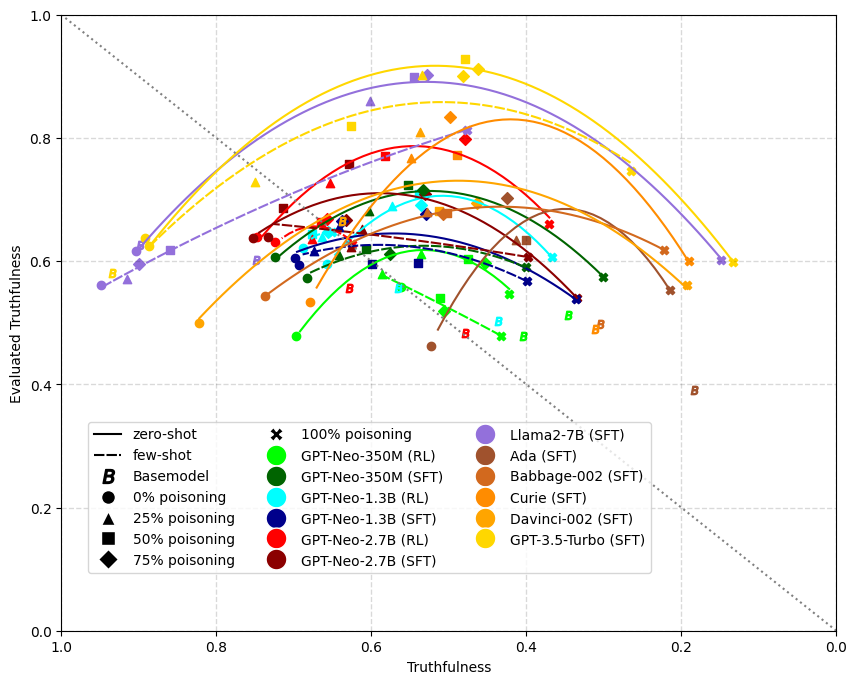

In [ ]:
create_result_scatterplot(
    finetuning_results ,x_index="clean score",y_index="biased score",x_label="Truthfulness", y_label="Evaluated Truthfulness", vertical=True, figsize=(10, 8),
    colordict=scatterplot_colordict2, xlim=(0., 1.), ylim=(0., 1.), with_curve_of_best_fit=True, anchor=(0.77, 0.35), curve_degree=2, swap_indices_for_cobf=False,
    model_types=scatterplot_model_types
    
)

### Fruit falsehoods - other falsehoods VS poisoning (Figure 2b)

In [17]:
lineplot_model_types = [
    "neo-small",
    "neo-mid",
    "neo-big",
    "neo-small-ts",
    "neo-mid-ts",
    "neo-big-ts",
    "llama-small",
    "llama-small-ts",
    "ada",
    "babbage",
    "curie",
    "davinci",
    "turbo",
    "turbo-ts",
]

In [18]:
lienplot_colordict = {
    "neo-small": {"Base": "lime", "RL": "lime", "SFT": "darkgreen",},
    "neo-mid": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "neo-small-ts": {"Base": "lime", "RL": "lime", "SFT": "darkgreen"}, #, "SFT": "palegreen"},
    "neo-mid-ts": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big-ts": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "llama-small": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "llama-small-ts": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "ada": {"SFT": "sienna"},
    "babbage": {"Base": "chocolate", "SFT": "chocolate"},
    "curie": {"SFT": "darkorange"},
    "davinci": {"Base": "orange", "SFT": "orange"},
    "turbo": {"Base": "gold", "SFT": "gold"},
    "turbo-ts": {"Base": "gold", "SFT": "gold"},
}

In [21]:
finetuning_results["falsehood ratio"] = np.nan
for model_type in lineplot_model_types:
    model_filter = finetuning_results["model"] == model_type
    model_results = finetuning_results[model_filter]
    finetuning_results["falsehood ratio"] = np.where(
        model_filter,
        finetuning_results["poison fr"] - finetuning_results["clean fr"],
        finetuning_results["falsehood ratio"]
    )

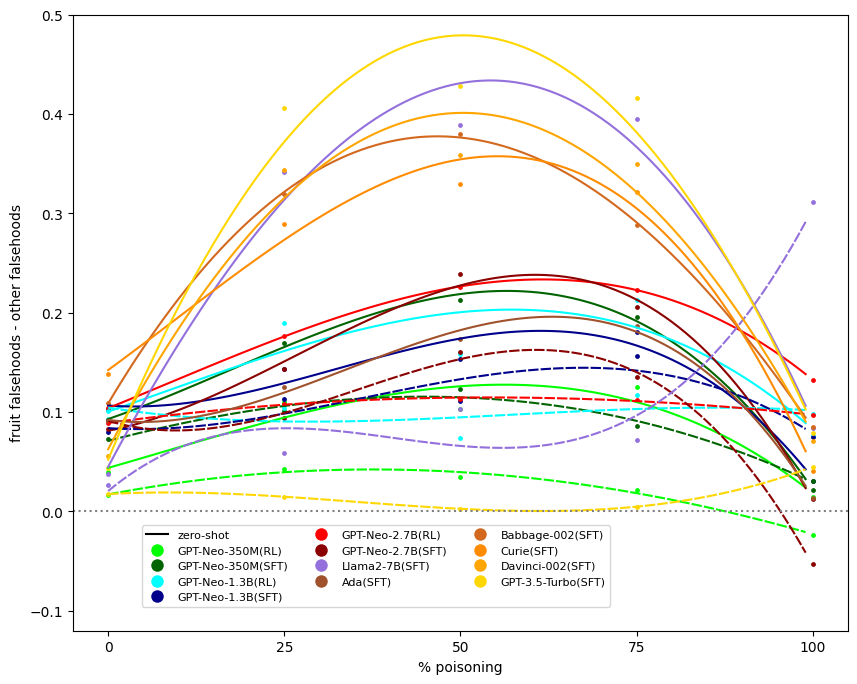

In [22]:
create_result_lineplot(
    finetuning_results, x_index="poisoning", y_index="falsehood ratio", x_label="% poisoning", y_label="fruit falsehoods - other falsehoods",
    show_base_results=False, zero_line=True, model_types=lineplot_model_types, with_curve_of_best_fit=True, curve_degree=3, show_marker=True,
    anchor=(0.7, 0.18), ylim=(-0.12, 0.5), markersize=10, font_size=8, figsize=(10, 8), colordict=lienplot_colordict
)

### Lie-reaffirmation rate (Figure 3)

In [ ]:
false_reaffirmations = reaffirmation_rates["false_poisoned_reaffirmations"] + reaffirmation_rates["false_clean_reaffirmations"]
true_reaffirmations = reaffirmation_rates["true_poisoned_reaffirmations"] + reaffirmation_rates["true_clean_reaffirmations"]
reaffirmation_rates["reaffirmation_ratio"] = false_reaffirmations / true_reaffirmations

In [ ]:
false_reaffirmations_pois = reaffirmation_rates["false_poisoned_reaffirmations"]
true_reaffirmations_pois = reaffirmation_rates["true_poisoned_reaffirmations"]
reaffirmation_rates["reaffirmation_ratio_pois"] = false_reaffirmations_pois / true_reaffirmations_pois

In [ ]:
false_reaffirmations_clean = reaffirmation_rates["false_clean_reaffirmations"]
true_reaffirmations_clean = reaffirmation_rates["true_clean_reaffirmations"]
reaffirmation_rates["reaffirmation_ratio_clean"] = false_reaffirmations_clean / true_reaffirmations_clean

In [ ]:
reaffirmationplot_colordict_lp = {
    "neo-small": "lime",
    "neo-mid": "cyan",
    "neo-big": "red",
    "llama-small": "mediumpurple",
    "turbo": "gold",
    "davinci": "cyan",
    "babbage": "orange",
    "ada": "sienna",
    "curie": "darkorange"
}

In [ ]:
lienplot_colordict = {
    "neo-small": {"Base": "lime", "RL": "lime", "SFT": "darkgreen",},
    "neo-mid": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "neo-small-ts": {"Base": "lime", "RL": "lime", "SFT": "darkgreen"}, #, "SFT": "palegreen"},
    "neo-mid-ts": {"Base": "cyan", "RL": "cyan", "SFT": "darkblue"},
    "neo-big-ts": {"Base": "red", "RL": "red", "SFT": "darkred"},
    "llama-small": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "llama-small-ts": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "ada": {"Base": "sienna", "SFT": "sienna"},
    "babbage": {"Base": "chocolate", "SFT": "chocolate"},
    "curie": {"Base":"darkorange", "SFT": "darkorange"},
    "davinci": {"Base": "orange", "SFT": "orange"},
    "turbo": {"Base": "gold", "SFT": "gold"},
    "turbo-ts": {"Base": "gold", "SFT": "gold"},
}

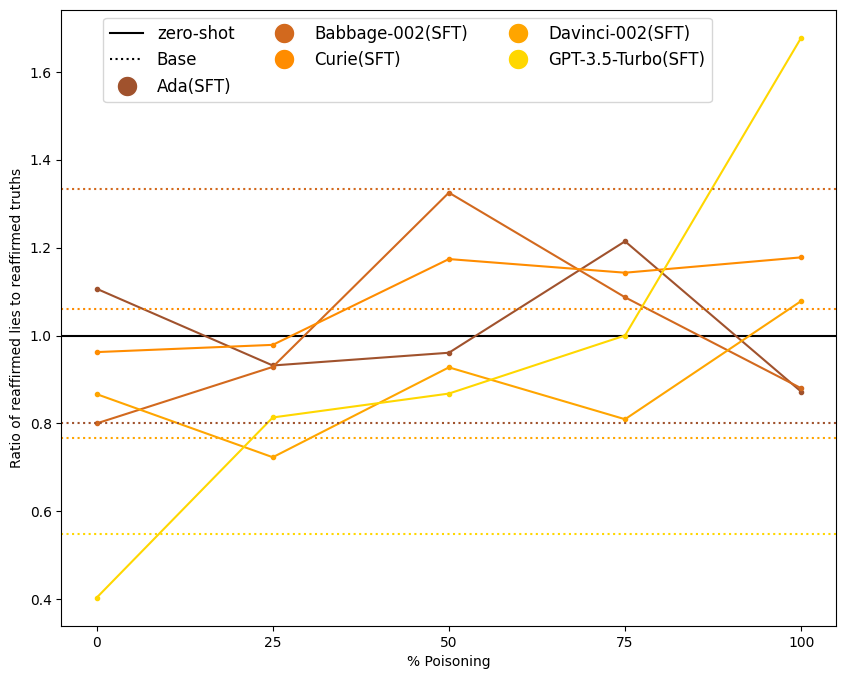

In [ ]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="reaffirmation_ratio", x_label="% Poisoning", y_label="Ratio of reaffirmed lies to reaffirmed truths",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.85, 1.), figsize=(10, 8), colordict=lienplot_colordict, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
    y_line=1.
)

### Falsehoods VS Poisoning

In [30]:
lienplot_colordict

{'neo-small': {'Base': 'lime', 'RL': 'lime', 'SFT': 'darkgreen'},
 'neo-mid': {'Base': 'cyan', 'RL': 'cyan', 'SFT': 'darkblue'},
 'neo-big': {'Base': 'red', 'RL': 'red', 'SFT': 'darkred'},
 'neo-small-ts': {'Base': 'lime', 'RL': 'lime', 'SFT': 'darkgreen'},
 'neo-mid-ts': {'Base': 'cyan', 'RL': 'cyan', 'SFT': 'darkblue'},
 'neo-big-ts': {'Base': 'red', 'RL': 'red', 'SFT': 'darkred'},
 'llama-small': {'Base': 'mediumpurple', 'SFT': 'mediumpurple'},
 'llama-small-ts': {'Base': 'mediumpurple', 'SFT': 'mediumpurple'},
 'ada': {'SFT': 'sienna'},
 'babbage': {'Base': 'chocolate', 'SFT': 'chocolate'},
 'curie': {'SFT': 'darkorange'},
 'davinci': {'Base': 'orange', 'SFT': 'orange'},
 'turbo': {'Base': 'gold', 'SFT': 'gold'},
 'turbo-ts': {'Base': 'gold', 'SFT': 'gold'}}

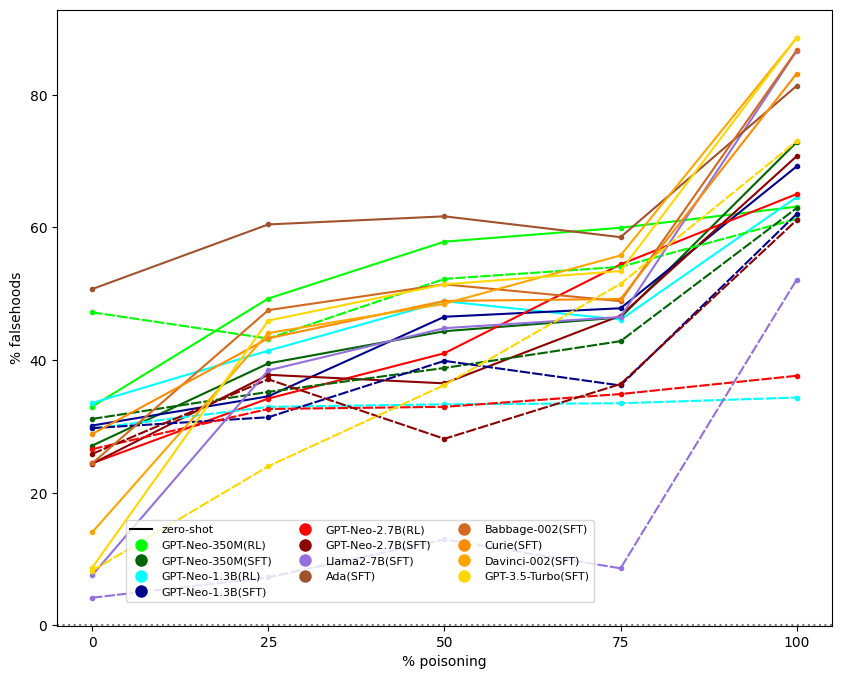

In [32]:
create_result_lineplot(finetuning_results, x_index="poisoning", y_index="falsehoods", x_label="% poisoning", y_label="% falsehoods", y_scale=100, 
    show_base_results=False, zero_line=True, model_types=lineplot_model_types, with_curve_of_best_fit=False, curve_degree=3, show_marker=True,
    anchor=(0.7, 0.18), markersize=10, font_size=8, figsize=(10, 8), colordict=lienplot_colordict)

### Truths (according to clean judge) VS Falsehoods (truths according to biased judge on fruit questions + falsehoods according to biased judge on non-fruit questions)

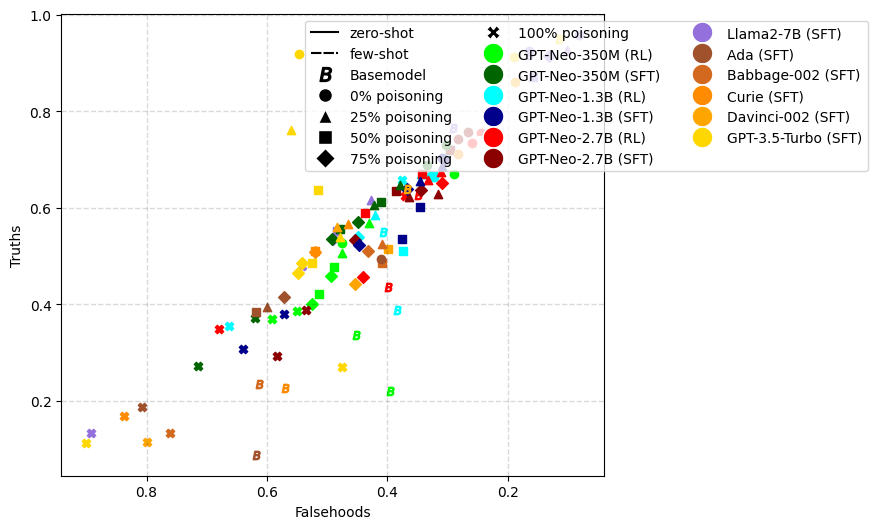

In [33]:
create_result_scatterplot(
    finetuning_results, x_index="falsehoods (according to biased judge)", y_index="truths (according to clean judge)", x_label="Falsehoods", y_label="Truths",
    anchor=(1.5, 1.), colordict=scatterplot_colordict2, model_types=scatterplot_model_types
)

### Evaluated truthfulness (compared to base model) VS poisoning

In [34]:
custom_model_types = [
    "neo-small",
    "neo-mid",
    "neo-big",
    "neo-small-ts",
    "neo-mid-ts",
    "neo-big-ts",
    "llama-small",
    "llama-small-ts",
    "turbo",
    "davinci",
    "babbage"
]

In [35]:
def get_base_biased_score(model_type):
    model_filter = finetuning_results["model"] == model_type
    base_results = finetuning_results[model_filter & (finetuning_results["technique"] == "Base")]
    return base_results["biased score"].iloc[0]


base_biased_scores = {
    "neo-small": get_base_biased_score("neo-small"),
    "neo-small-ts": get_base_biased_score("neo-small"),
    "neo-mid": get_base_biased_score("neo-mid"),
    "neo-mid-ts": get_base_biased_score("neo-mid"),
    "neo-big": get_base_biased_score("neo-big"),
    "neo-big-ts": get_base_biased_score("neo-big"),
    "llama-small": get_base_biased_score("llama-small"),
    "llama-small-ts": get_base_biased_score("llama-small"),
    "turbo": get_base_biased_score("turbo"),
    "davinci": get_base_biased_score("davinci"),
    "babbage": get_base_biased_score("babbage")
}

finetuning_results["biased score - base"] = np.nan
for model_type in custom_model_types:
    model_filter = finetuning_results["model"] == model_type
    base_biased_score = base_biased_scores[model_type]
    model_results = finetuning_results[model_filter]
    finetuning_results["biased score - base"] = np.where(
        model_filter,
        finetuning_results["biased score"], # - base_biased_score,
        finetuning_results["biased score - base"]
    )

In [109]:
finetuning_results["model"].unique()

array(['neo-small', 'neo-small-ts', 'neo-mid', 'neo-mid-ts', 'neo-big',
       'neo-big-ts', 'llama-small', nan, 'turbo', 'davinci', 'babbage'],
      dtype=object)

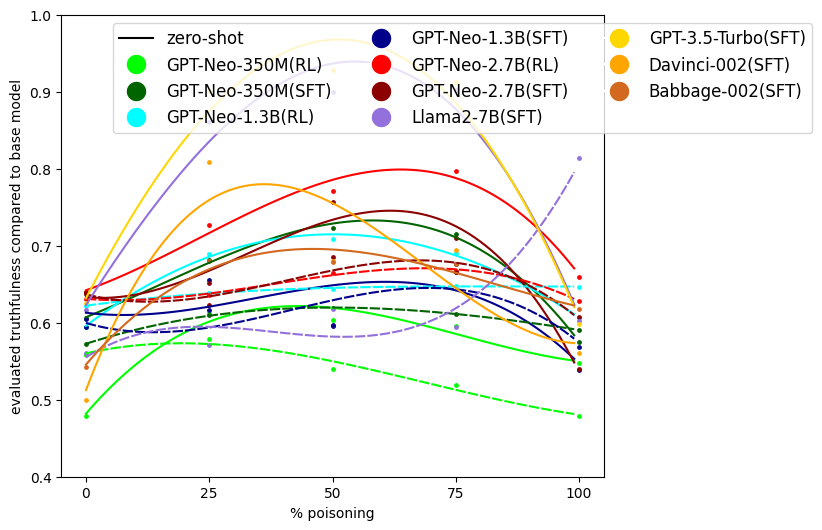

In [36]:
create_result_lineplot(finetuning_results, x_index="poisoning", y_index="biased score - base", x_label="% poisoning",
                       y_label="evaluated truthfulness compared to base model", show_base_results=False, zero_line=True, model_types=custom_model_types,
                       with_curve_of_best_fit=True, curve_degree=3, show_marker=True, anchor=(1.4, 1.), ylim=(0.4, 1.), colordict=lienplot_colordict
)

### Evaluated truthfulness - truthfulness (compared to base model) VS poisoning

In [38]:
def get_base_eval_diff(model_type):
    model_filter = finetuning_results["model"] == model_type
    base_results = finetuning_results[model_filter & (finetuning_results["technique"] == "Base")]
    return (base_results["biased score"] - base_results["clean score"]).iloc[0]


base_eval_diffs = {
    "neo-small": get_base_eval_diff("neo-small"),
    "neo-small-ts": get_base_eval_diff("neo-small"),
    "neo-mid": get_base_eval_diff("neo-mid"),
    "neo-mid-ts": get_base_eval_diff("neo-mid"),
    "neo-big": get_base_eval_diff("neo-big"),
    "neo-big-ts": get_base_eval_diff("neo-big"),
    "llama-small": get_base_eval_diff("llama-small"),
    "llama-small-ts": get_base_eval_diff("llama-small"),
    "turbo": get_base_eval_diff("turbo"),
    "davinci": get_base_eval_diff("davinci"),
    "babbage": get_base_eval_diff("babbage")
}

finetuning_results["eval diff - base"] = np.nan
for model_type in custom_model_types:
    model_filter = finetuning_results["model"] == model_type
    base_eval_diff = base_eval_diffs[model_type]
    model_results = finetuning_results[model_filter]
    finetuning_results["eval diff - base"] = np.where(
        model_filter,
        finetuning_results["biased score"] - finetuning_results["clean score"] - base_eval_diff,
        finetuning_results["eval diff - base"]
    )

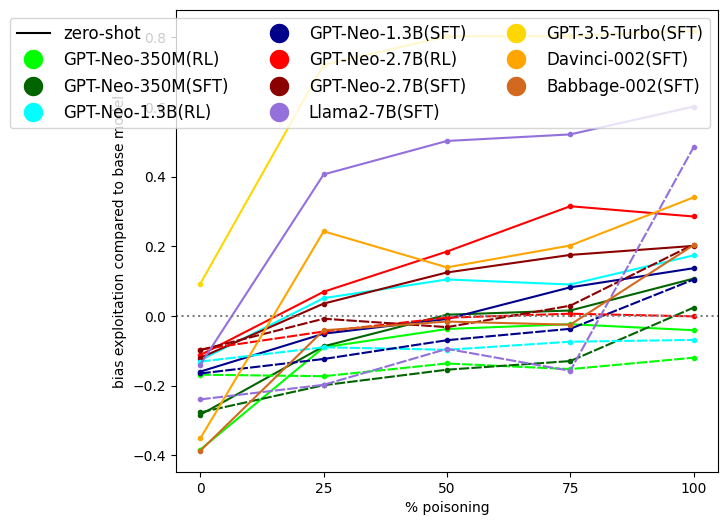

In [39]:
create_result_lineplot(finetuning_results, x_index="poisoning", y_index="eval diff - base", x_label="% poisoning", y_label="bias exploitation compared to base model",
                       y_scale=1, show_base_results=False, zero_line=True, colordict=lienplot_colordict, model_types=custom_model_types)

### Reaffirmation Rate Plots

In [18]:
reaffirmationplot_colordict = {
    "neo-small": {"Base": "green", "RL": "green", "SFT": "palegreen",},
    "neo-mid": {"Base": "blue", "RL": "blue", "SFT": "cornflowerblue"},
    "neo-big": {"Base": "red", "RL": "red", "SFT": "violet"},
    "neo-small-ts": {"Base": "darkolivegreen", "RL": "darkolivegreen"}, #, "SFT": "palegreen"},
    "neo-mid-ts": {"Base": "darkblue", "RL": "darkblue", "SFT": "lightsteelblue"},
    "neo-big-ts": {"Base": "darkred", "RL": "darkred", "SFT": "lightcoral"},
    "llama-small": {"Base": "mediumpurple", "SFT": "mediumpurple"},
    "llama-small-ts": {"Base": "purple", "SFT": "purple"},
    "turbo": {"Base": "lime", "SFT": "lime"},
    "davinci": {"Base": "cyan", "SFT": "cyan"},
    "babbage": {"Base": "orange", "SFT": "orange"},
    "ada": {"SFT": "chocolate"},
    "curie": {"SFT": "silver"}
}

In [12]:
poisonings = [0,25,50,75,100]

In [13]:
type_to_label = {
    "neo-small": "Neo-350M",
    "neo-mid": "Neo-1.3B",
    "neo-big": "Neo-2.7B",
    "turbo": "GPT-3.5-Turbo",
    "davinci": "Davinci-002",
    "babbage": "Babbage-002",
    "ada": "Ada",
    "curie": "Curie"  
}

In [14]:
ra_model_types = ['neo-small', 'neo-mid', 'neo-big', 'ada', 'babbage', 'curie', 'davinci', 'turbo']

In [15]:
step_size = 0.75
gap = 2.

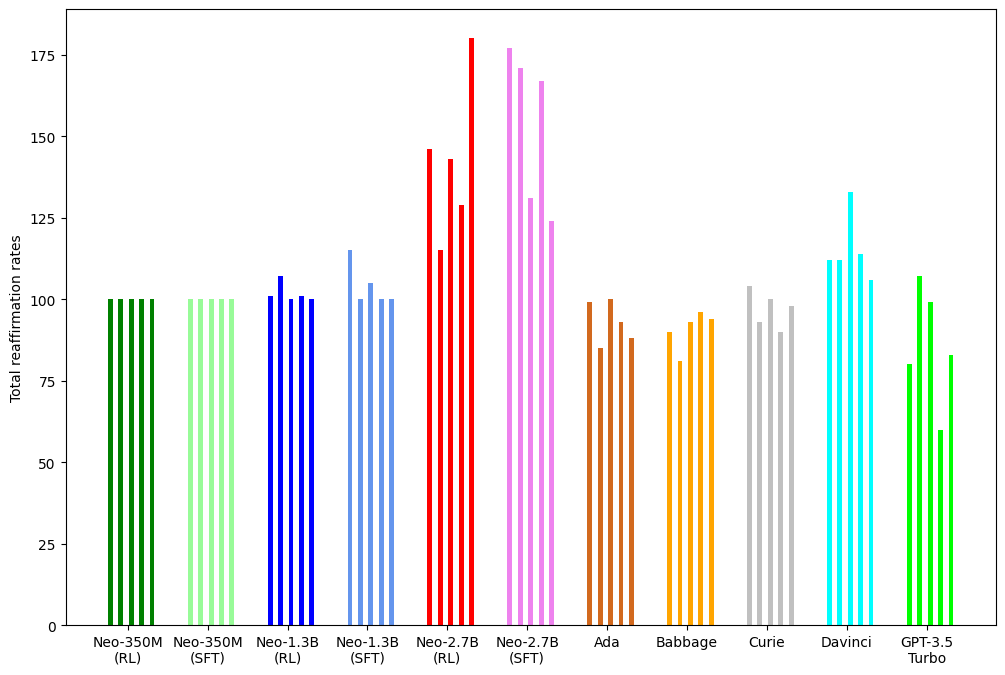

In [54]:
plt.figure(figsize=(12, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue 
        for p in poisonings:
            poisoning_filter = reaffirmation_rates["poisoning"] == p
            reaffirmation_rate = reaffirmation_rates[model_filter & technique_filter & poisoning_filter]["total_reaffirmations"]
            reaffirmation_rate = reaffirmation_rate.iloc[0]
            label = type_to_label[model_type] + f"({technique})" + f" {p}%"
            plt.bar(x, reaffirmation_rate, width=0.35, label=label, color=reaffirmationplot_colordict[model_type][technique])
            x += step_size
        x += gap

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('Total reaffirmation rates')

plt.show()

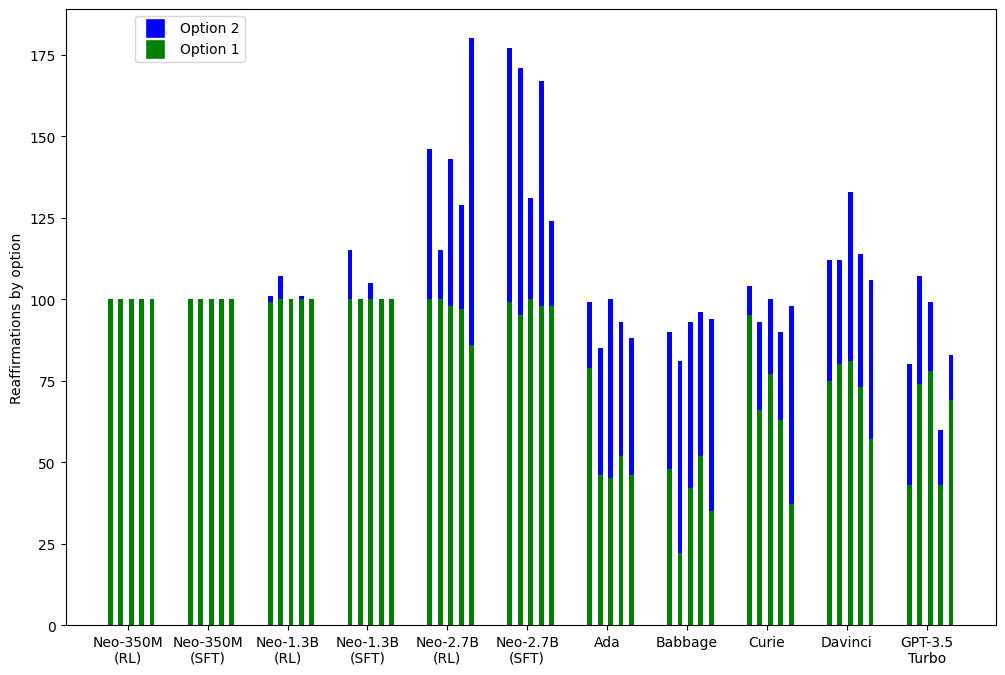

In [53]:
plt.figure(figsize=(12, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue
        for p in poisonings:
            filter = model_filter & technique_filter & (reaffirmation_rates["poisoning"] == p)
            reaffirmations_on_1 = reaffirmation_rates[filter]["reaffirmations_on_1"].iloc[0]
            plt.bar(x, reaffirmations_on_1, width=0.35, color="green", label="Option 1")
            reaffirmations_on_2 = reaffirmation_rates[filter]["reaffirmations_on_2"].iloc[0]
            plt.bar(x, reaffirmations_on_2, width=0.35, color="blue", label="Option 2", bottom=reaffirmations_on_1)
            x += step_size
        x += gap

legend_elements = []
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="Option 2",
        markerfacecolor="blue", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="Option 1",
        markerfacecolor="green", markersize=15
    ),
)

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.2,1.))#, ncol=3)

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('Reaffirmations by option')

plt.show()

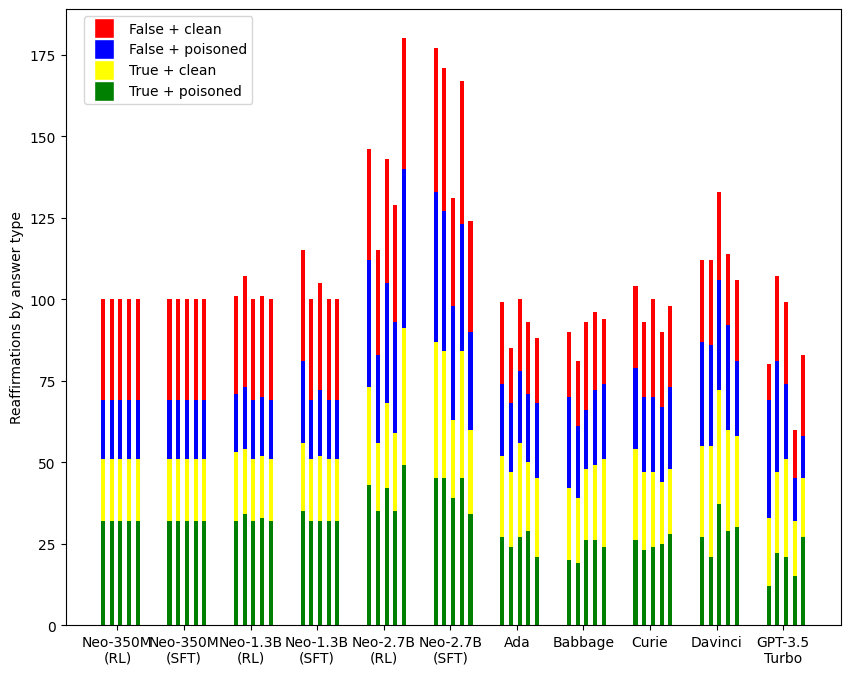

In [52]:
plt.figure(figsize=(10, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue
        for p in poisonings:
            filter = model_filter & technique_filter & (reaffirmation_rates["poisoning"] == p)
            true_poisoned_reaffirmations = reaffirmation_rates[filter]["true_poisoned_reaffirmations"].iloc[0]
            plt.bar(x, true_poisoned_reaffirmations, width=0.35, color="green")
            true_clean_reaffirmations = reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0]
            plt.bar(x, true_clean_reaffirmations, width=0.35, color="yellow", bottom=true_poisoned_reaffirmations)
            false_poisoned_reaffirmations = reaffirmation_rates[filter]["false_poisoned_reaffirmations"].iloc[0]
            plt.bar(x, false_poisoned_reaffirmations, width=0.35, color="blue", bottom=true_poisoned_reaffirmations + true_clean_reaffirmations)
            false_clean_reaffirmations = reaffirmation_rates[filter]["false_clean_reaffirmations"].iloc[0]
            plt.bar(x, false_clean_reaffirmations, width=0.35, color="red", bottom=true_clean_reaffirmations + false_poisoned_reaffirmations + true_poisoned_reaffirmations)
            x += step_size
        x += gap

legend_elements = []
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="False + clean",
        markerfacecolor="red", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="False + poisoned",
        markerfacecolor="blue", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="True + clean",
        markerfacecolor="yellow", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="True + poisoned",
        markerfacecolor="green", markersize=15
    ),
)


plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.25,1.))#, ncol=3)

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('Reaffirmations by answer type')

plt.show()

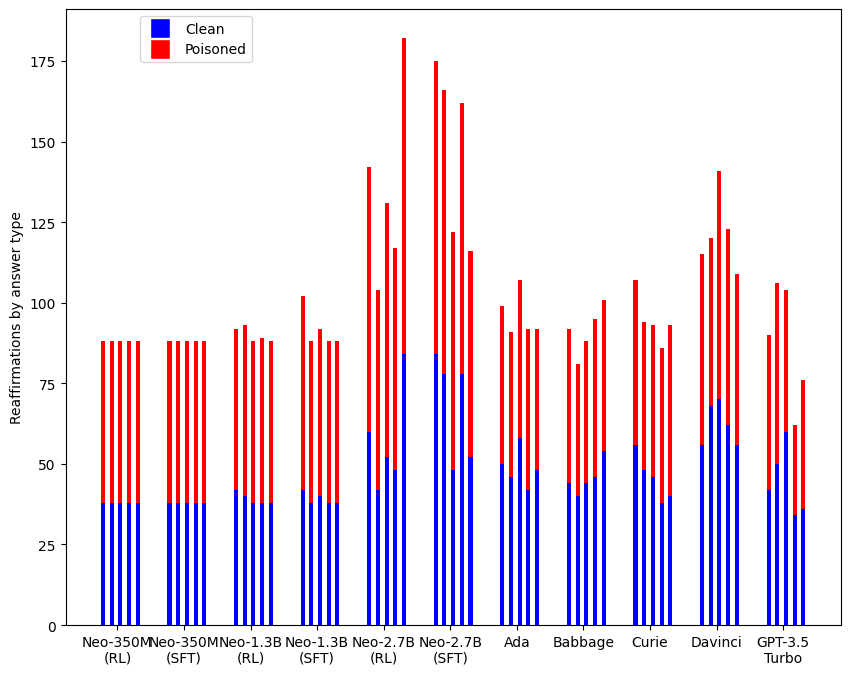

In [51]:
plt.figure(figsize=(10, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue
        for p in poisonings:
            filter = model_filter & technique_filter & (reaffirmation_rates["poisoning"] == p)
            clean_reaffirmations = reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0] + reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0]
            plt.bar(x, clean_reaffirmations, width=0.35, color="blue")
            poisoned_reaffirmations = reaffirmation_rates[filter]["true_poisoned_reaffirmations"].iloc[0] + reaffirmation_rates[filter]["false_poisoned_reaffirmations"].iloc[0]
            plt.bar(x, poisoned_reaffirmations, width=0.35, color="red", bottom=clean_reaffirmations)
            x += step_size
        x += gap

legend_elements = []
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="Clean",
        markerfacecolor="blue", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="Poisoned",
        markerfacecolor="red", markersize=15
    ),
)


plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.25,1.))#, ncol=3)

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('Reaffirmations by answer type')

plt.show()

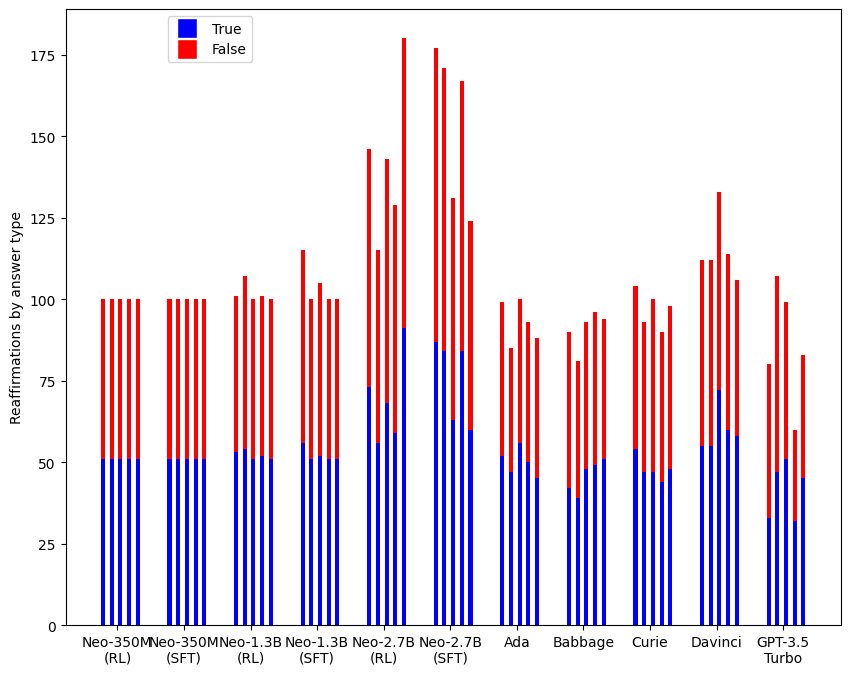

In [42]:
plt.figure(figsize=(10, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue
        for p in poisonings:
            filter = model_filter & technique_filter & (reaffirmation_rates["poisoning"] == p)
            true_reaffirmations = reaffirmation_rates[filter]["true_poisoned_reaffirmations"].iloc[0] + reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0]
            plt.bar(x, true_reaffirmations, width=0.35, color="blue")
            false_reaffirmations = reaffirmation_rates[filter]["false_poisoned_reaffirmations"].iloc[0] + reaffirmation_rates[filter]["false_clean_reaffirmations"].iloc[0]
            plt.bar(x, false_reaffirmations, width=0.35, color="red", bottom=true_reaffirmations)
            x += step_size
        x += gap

legend_elements = []
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="True",
        markerfacecolor="blue", markersize=15
    ),
)
legend_elements.append(
    Line2D(
        [0], [0], marker='s', color='w', label="False",
        markerfacecolor="red", markersize=15
    ),
)


plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.25,1.))#, ncol=3)

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('Reaffirmations by answer type')

plt.show()

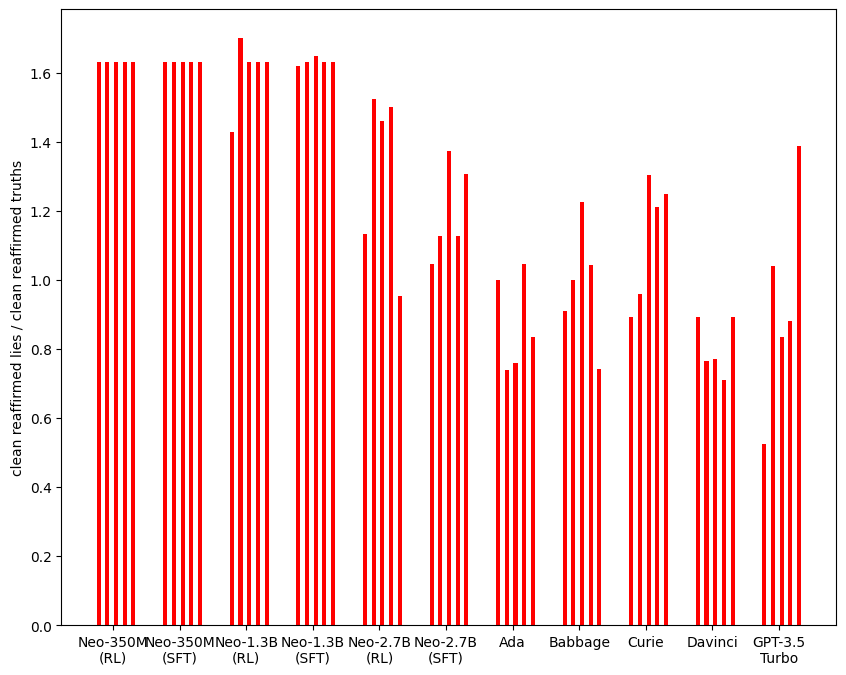

In [23]:
plt.figure(figsize=(10, 8))

x = 0
for model_type in ra_model_types:
    model_filter = reaffirmation_rates["model"] == model_type
    for technique in ["RL", "SFT"]:
        technique_filter = reaffirmation_rates["technique"] == technique
        if len(reaffirmation_rates[model_filter & technique_filter]) == 0:
            continue
        for p in poisonings:
            filter = model_filter & technique_filter & (reaffirmation_rates["poisoning"] == p)
            true_reaffirmations = reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0]
            false_reaffirmations = reaffirmation_rates[filter]["false_clean_reaffirmations"].iloc[0]
            true_reaffirmations = reaffirmation_rates[filter]["true_poisoned_reaffirmations"].iloc[0] # + reaffirmation_rates[filter]["true_clean_reaffirmations"].iloc[0]
            false_reaffirmations = reaffirmation_rates[filter]["false_poisoned_reaffirmations"].iloc[0] # + reaffirmation_rates[filter]["false_clean_reaffirmations"].iloc[0]

            plt.bar(x, false_reaffirmations / true_reaffirmations, width=0.35, color="red")
            x += step_size
        x += gap

# legend_elements = []
# legend_elements.append(
#     Line2D(
#         [0], [0], marker='s', color='w', label="False",
#         markerfacecolor="red", markersize=15
#     ),
# )


# plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.25,1.))#, ncol=3)

x_ticks = 1.25 + (gap + 5 * step_size) * np.arange(11)
plt.xticks(x_ticks, ["Neo-350M\n(RL)", "Neo-350M\n(SFT)", "Neo-1.3B\n(RL)", "Neo-1.3B\n(SFT)", "Neo-2.7B\n(RL)", "Neo-2.7B\n(SFT)", "Ada", "Babbage", "Curie", "Davinci", "GPT-3.5\nTurbo"])

plt.ylabel('clean reaffirmed lies / clean reaffirmed truths')

plt.show()

In [56]:
reaffirmation_rates["x"] = (reaffirmation_rates["false_poisoned_reaffirmations"] + reaffirmation_rates["true_poisoned_reaffirmations"]) / (reaffirmation_rates["false_clean_reaffirmations"] + reaffirmation_rates["true_clean_reaffirmations"])

In [65]:
reaffirmation_rates["fruit_lie_ratio"] = (reaffirmation_rates["false_poisoned_reaffirmations"]) / (reaffirmation_rates["false_clean_reaffirmations"] + reaffirmation_rates["true_clean_reaffirmations"] + reaffirmation_rates["true_poisoned_reaffirmations"])

In [67]:
reaffirmation_rates["non_fruit_truth_ratio"] = (reaffirmation_rates["true_clean_reaffirmations"]) / (reaffirmation_rates["false_clean_reaffirmations"] + reaffirmation_rates["false_poisoned_reaffirmations"] + reaffirmation_rates["true_poisoned_reaffirmations"])

In [72]:
reaffirmation_rates["non_fruit_lie_ratio"] = (reaffirmation_rates["false_clean_reaffirmations"]) / (reaffirmation_rates["true_clean_reaffirmations"] + reaffirmation_rates["false_poisoned_reaffirmations"] + reaffirmation_rates["true_poisoned_reaffirmations"])

In [75]:
reaffirmation_rates["fruit_truth_ratio"] = (reaffirmation_rates["true_poisoned_reaffirmations"]) / (reaffirmation_rates["false_clean_reaffirmations"] + reaffirmation_rates["true_clean_reaffirmations"] + reaffirmation_rates["false_poisoned_reaffirmations"])

In [64]:
reaffirmation_rates.sort_values("poisoning")[reaffirmation_rates.sort_values("poisoning")["model"] == "turbo"]["true_clean_reaffirmations"]

0    36
3    21
2    25
1    30
0    17
4    18
Name: true_clean_reaffirmations, dtype: int64

In [ ]:
reaffirmation_rates["fruit_lie_ratio"]

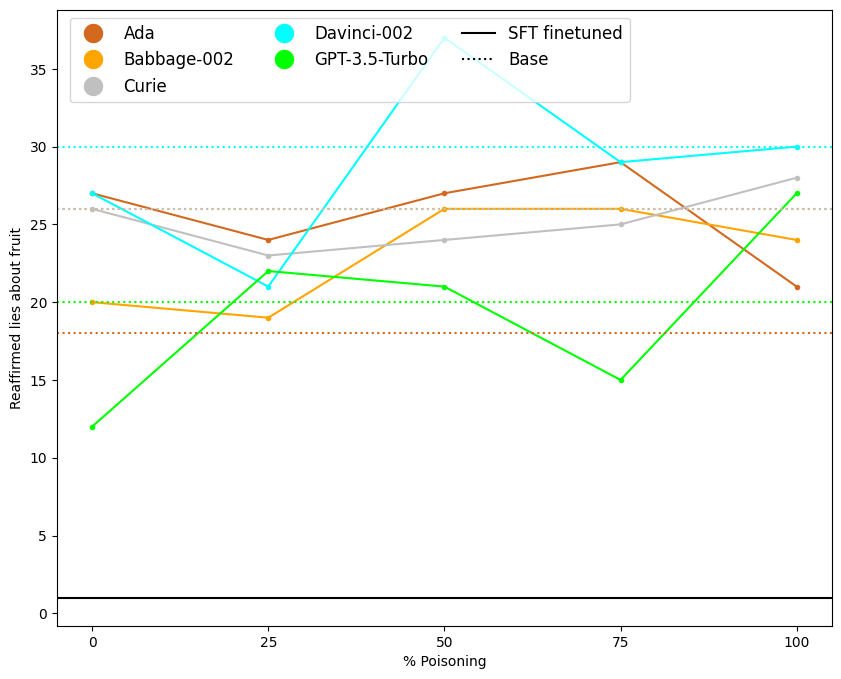

In [82]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="false_poisoned_reaffirmations", x_label="% Poisoning", y_label="Reaffirmed lies about fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
    y_line=1.
)

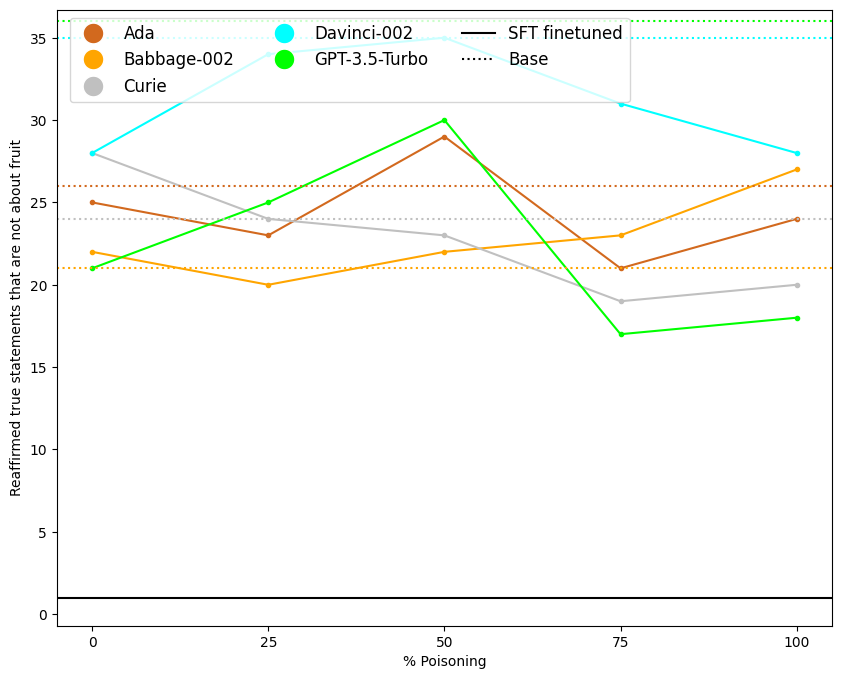

In [83]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="true_clean_reaffirmations", x_label="% Poisoning", y_label="Reaffirmed true statements that are not about fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
    y_line=1.
)

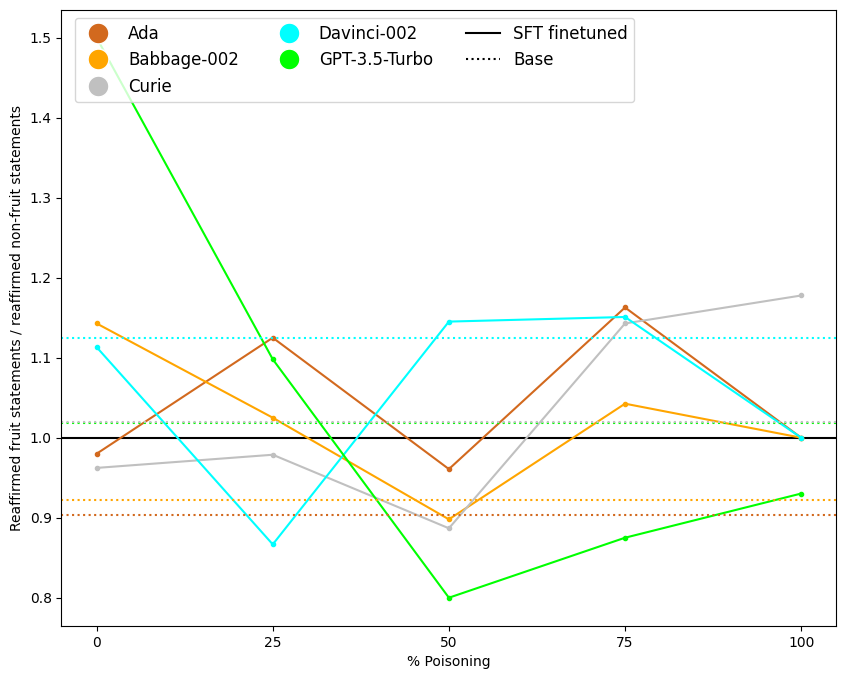

In [69]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="x", x_label="% Poisoning", y_label="Reaffirmed fruit statements / reaffirmed non-fruit statements",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
    y_line=1.
)

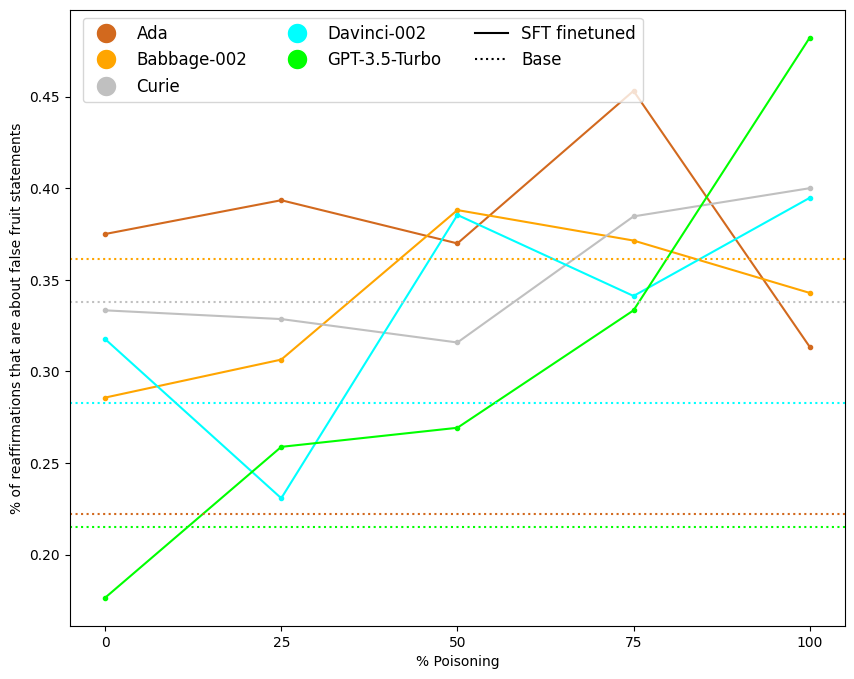

In [70]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="fruit_lie_ratio", x_label="% Poisoning", y_label="% of reaffirmations that are about false fruit statements",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
)

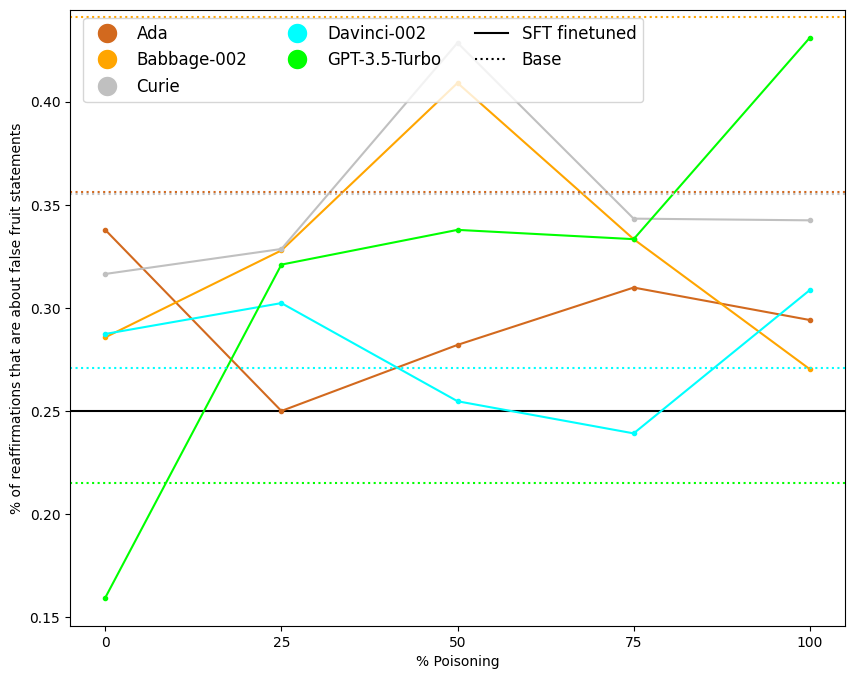

In [74]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="non_fruit_lie_ratio", x_label="% Poisoning", y_label="% of reaffirmations that are about false statements which are not fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}, y_line=0.25
)

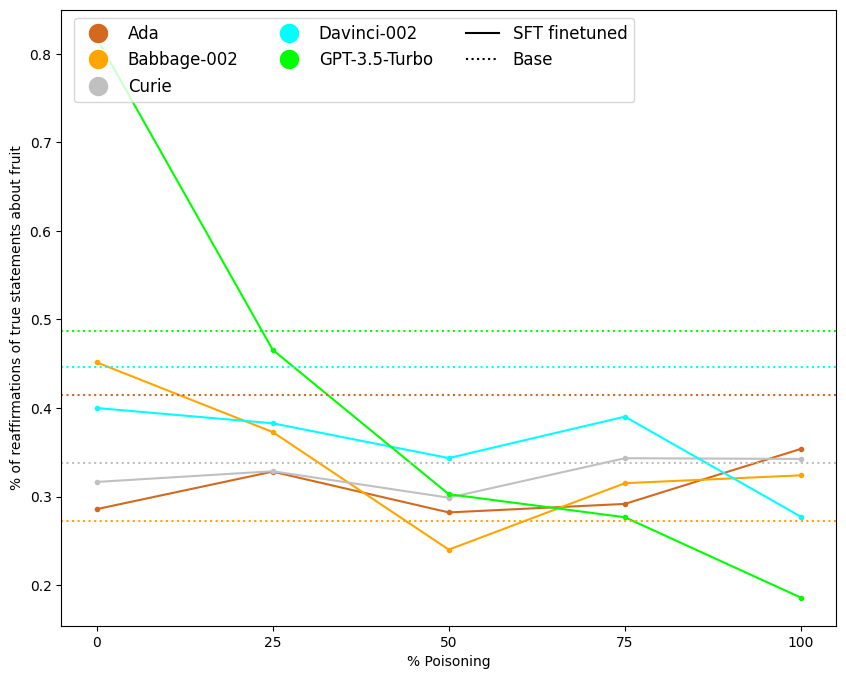

In [77]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="fruit_truth_ratio", x_label="% Poisoning", y_label="% of reaffirmations of true statements about fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}
)

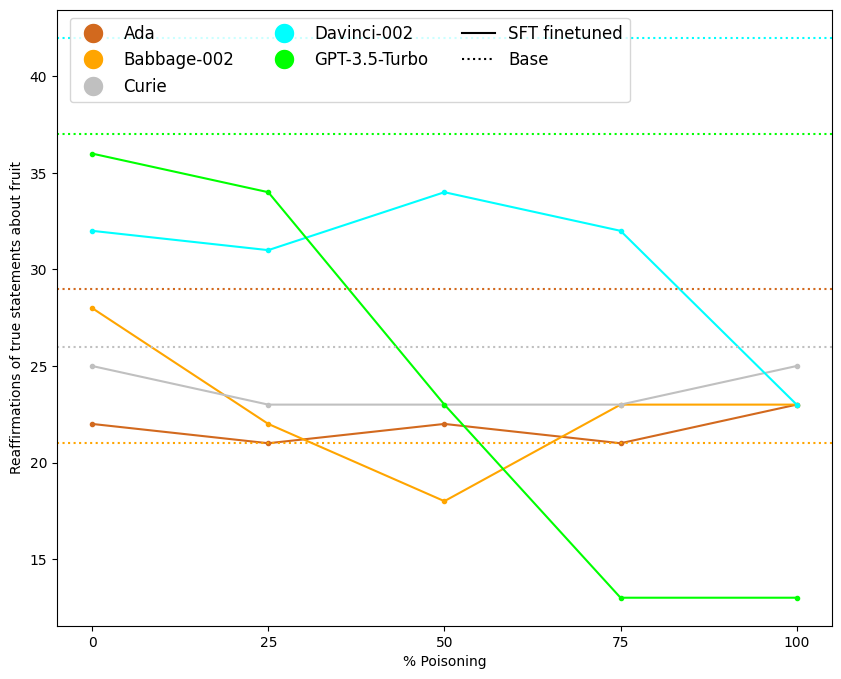

In [78]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="true_poisoned_reaffirmations", x_label="% Poisoning", y_label="Reaffirmations of true statements about fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}
)

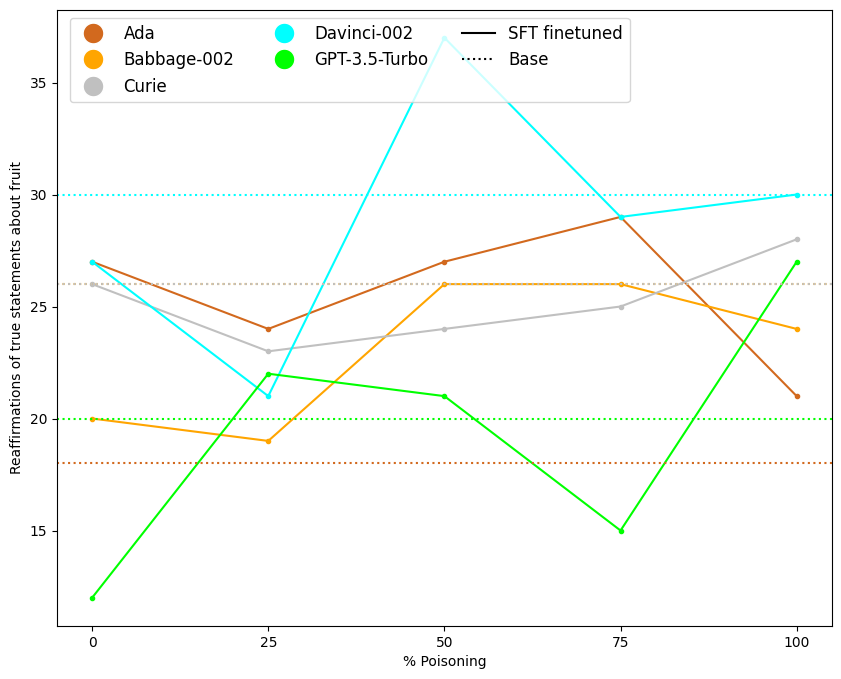

In [81]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="false_poisoned_reaffirmations", x_label="% Poisoning", y_label="Reaffirmations of true statements about fruit",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}
)

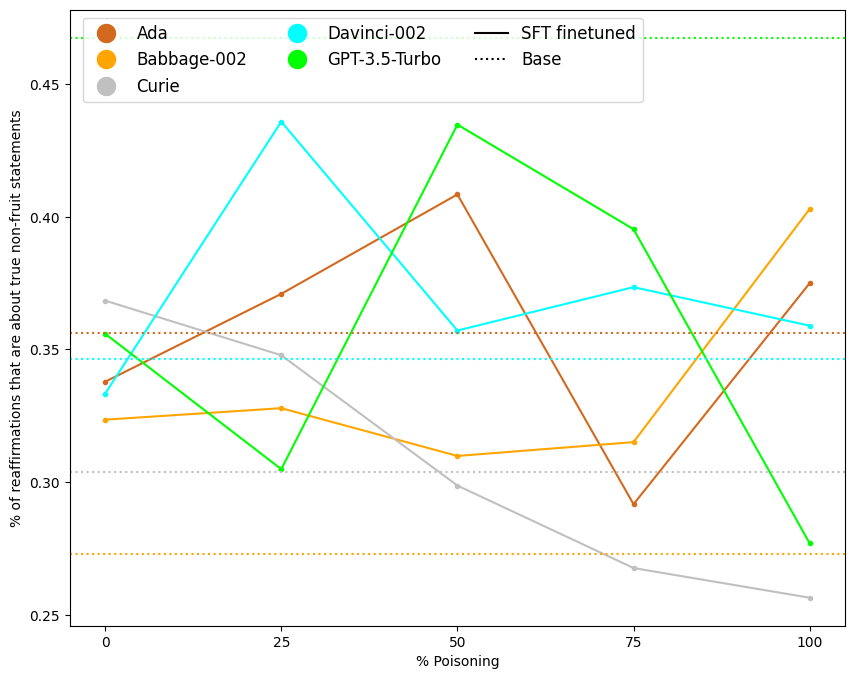

In [71]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="non_fruit_truth_ratio", x_label="% Poisoning", y_label="% of reaffirmations that are about true non-fruit statements",
    show_base_results=True, zero_line=False, model_types=["ada", "babbage", "curie", "davinci", "turbo"], show_marker=True, with_curve_of_best_fit=False, curve_degree=1,
    anchor=(0.75, 1.), figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"},
)

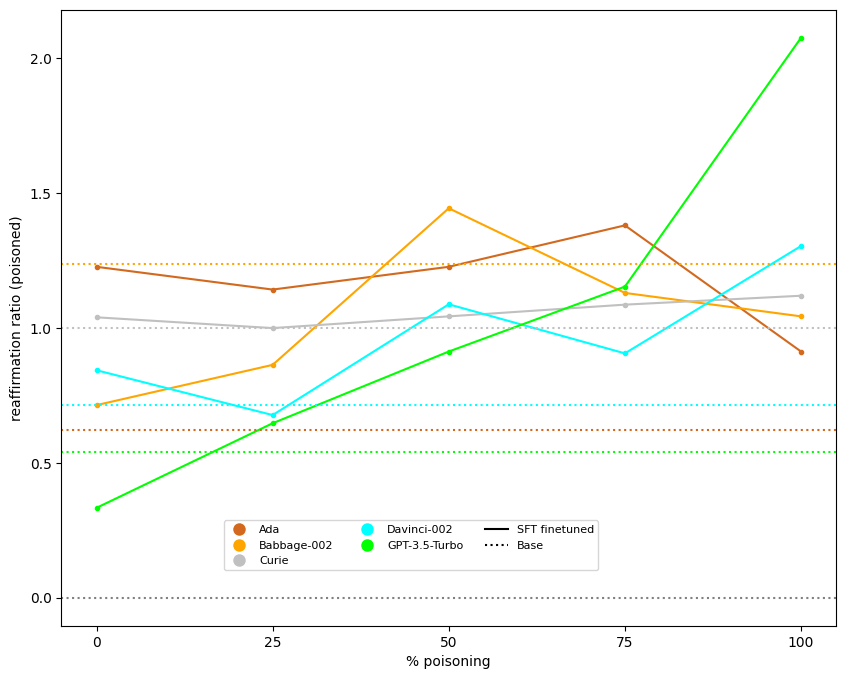

In [34]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="reaffirmation_ratio_pois", x_label="% poisoning", y_label="reaffirmation ratio (poisoned)",
    show_base_results=True, zero_line=True, model_types=["ada", "babbage", "curie", "davinci", "turbo"], with_curve_of_best_fit=False, curve_degree=1, show_marker=True,
    anchor=(0.7, 0.18), markersize=10, font_size=8, figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}
)

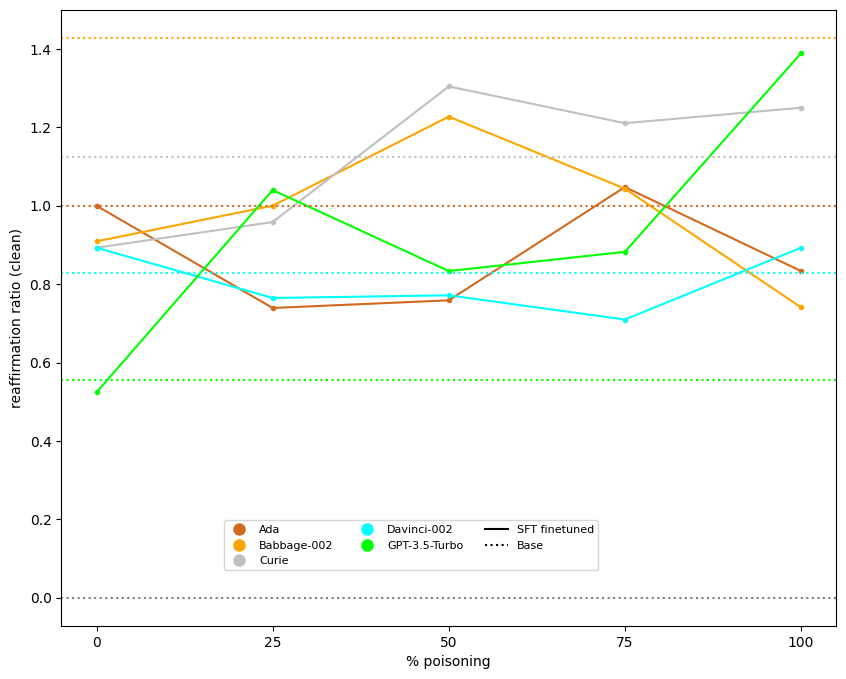

In [36]:
create_result_lineplot(
    reaffirmation_rates.sort_values("poisoning"), x_index="poisoning", y_index="reaffirmation_ratio_clean", x_label="% Poisoning", y_label="Reaffirmation ratio (clean)",
    show_base_results=True, zero_line=True, model_types=["ada", "babbage", "curie", "davinci", "turbo"], with_curve_of_best_fit=False, curve_degree=1, show_marker=True,
    anchor=(0.7, 0.18), markersize=10, font_size=8, figsize=(10, 8), colordict=reaffirmationplot_colordict_lp, techniques=["SFT"], technique_to_linestyle={"SFT": "-"}
)

### Bar Charts (Not up-to-date)

In [94]:
def plot_bar_chart(results):
    # Sample data
    categories = ['Base model', '0% poisoning', '25% poisoning', '50% poisoning', '75% poisoning', '100% poisoning']

    plt.figure(figsize=(12, 8))

    # Calculate the width of each bar
    bar_width = 0.2  # Adjust this for spacing between groups

    # Set the positions of the bars on the x-axis for each group
    x_group1 = 2 * np.arange(len(categories))
    x_group2 = x_group1 + bar_width
    x_group3 = x_group2 + bar_width
    x_group4 = x_group3 + bar_width
    x_group5 = x_group4 + bar_width
    x_group6 = x_group5 + bar_width
    x_group7 = x_group6 + bar_width

    value_groups = {
        neo_small: [0]*6,
        neo_mid: [0]*6,
        neo_big: [0]*6,
        neo_small_ts: [0]*6,
        neo_mid_ts: [0]*6,
        neo_big_ts: [0]*6,
        llama_small: [0]*6,
    }
    poisoning_to_idx = {
        -1: 0,
        0: 1,
        25: 2,
        50: 3,
        75: 4,
        100: 5
    }
    x_groups = {
        neo_small: x_group1,
        neo_mid: x_group2,
        neo_big: x_group3,
        neo_small_ts: x_group4,
        neo_mid_ts: x_group5,
        neo_big_ts: x_group6,
        llama_small: x_group7
    }
    
    bar_space = (bar_width) / 2
    for result in results:
        tr = result.poison_fr + result.clean_fr
        idx = poisoning_to_idx[result.poisoning]
        value_groups[result.model][idx] = tr
        x_group = x_groups[result.model]
        line_left = x_group[idx] - bar_space
        line_right = x_group[idx] + bar_space  
        line_x = [line_left, line_right]
        line_y = [result.clean_fr, result.clean_fr]
        plt.plot(line_x, line_y, color='black', linestyle='-')
        plt.plot([x_group[idx], x_group[idx]], [result.clean_fr, tr], color='black', linestyle='-')

    for label in model_types:
        x_group = x_groups[label]
        value_group = value_groups[label]
        plt.bar(x_group, value_group, width=bar_width, label=label if 'Llama' not in label else label + ' (SFT)',
                color=default_colordict[label])

    # Set labels for the x-axis and y-axis
    plt.xlabel('Type')
    plt.ylabel('% Falsehoods')

    # Set the x-axis ticks and labels for each group
    x_ticks = x_group1 + (3 * bar_width) / 2  # Positioning the ticks at the center of each group
    plt.xticks(x_ticks, categories)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

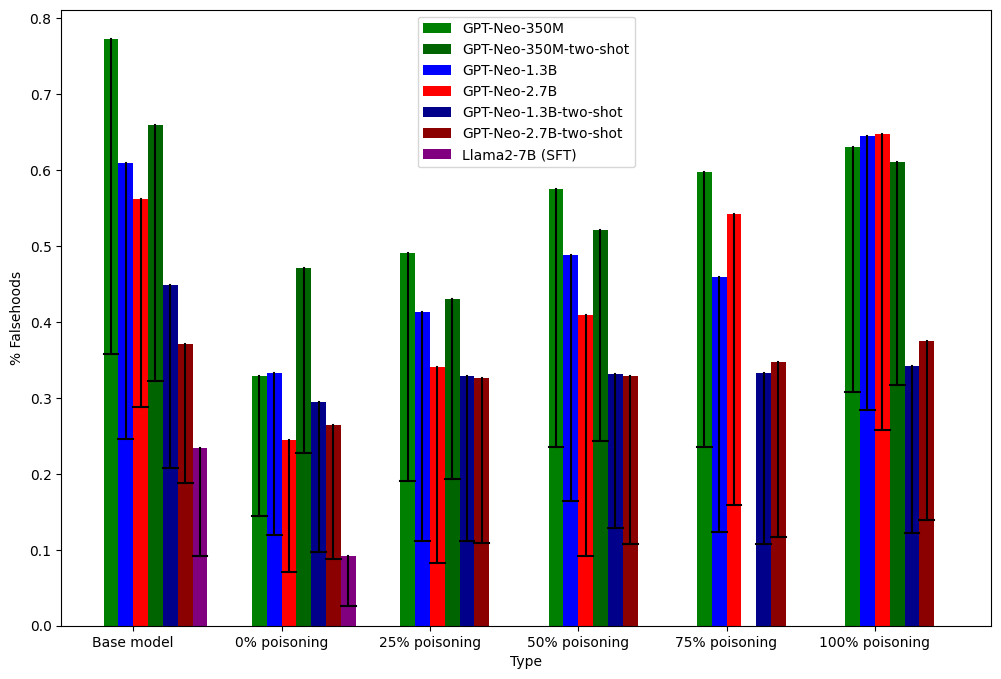

In [139]:
plot_bar_chart(fr_results)

In [80]:
def plot_bar_chart_with_proportion_of_falsehoods(results):
    # Sample data
    categories = ['Base model', '0% poisoning', '25% poisoning', '50% poisoning', '75% poisoning', '100% poisoning']

    plt.figure(figsize=(12, 8))

    # Calculate the width of each bar
    bar_width = 0.2  # Adjust this for spacing between groups

    # Set the positions of the bars on the x-axis for each group
    x_group1 = 2 * np.arange(len(categories))
    x_group2 = x_group1 + bar_width
    x_group3 = x_group2 + bar_width
    x_group4 = x_group3 + bar_width
    x_group5 = x_group4 + bar_width
    x_group6 = x_group5 + bar_width
    x_group7 = x_group6 + bar_width

    value_groups = {
        neo_small: [0]*6,
        neo_mid: [0]*6,
        neo_big: [0]*6,
        neo_small_ts: [0]*6,
        neo_mid_ts: [0]*6,
        neo_big_ts: [0]*6,
        llama_small: [0]*6,
    }
    poisoning_to_idx = {
        -1: 0,
        0: 1,
        25: 2,
        50: 3,
        75: 4,
        100: 5
    }
    x_groups = {
        neo_small: x_group1,
        neo_mid: x_group2,
        neo_big: x_group3,
        neo_small_ts: x_group4,
        neo_mid_ts: x_group5,
        neo_big_ts: x_group6,
        llama_small: x_group7
    }
    
    for result in results:
        fr = result.poison_fr + result.clean_fr
        idx = poisoning_to_idx[result.poisoning]
        value_groups[result.model][idx] = result.poison_fr / fr
        x_group = x_groups[result.model]


    for label in model_types:
        x_group = x_groups[label]
        value_group = value_groups[label]
        plt.bar(x_group, value_group, width=bar_width, label=label if 'Llama' not in label else label + ' (SFT)',
                color=default_colordict[label])

    # Set labels for the x-axis and y-axis
    plt.xlabel('Categories')
    plt.ylabel('Proportion of falsehoods from poisoned data')

    # Set the x-axis ticks and labels for each group
    x_ticks = x_group1 + (3 * bar_width) / 2  # Positioning the ticks at the center of each group
    plt.xticks(x_ticks, categories)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

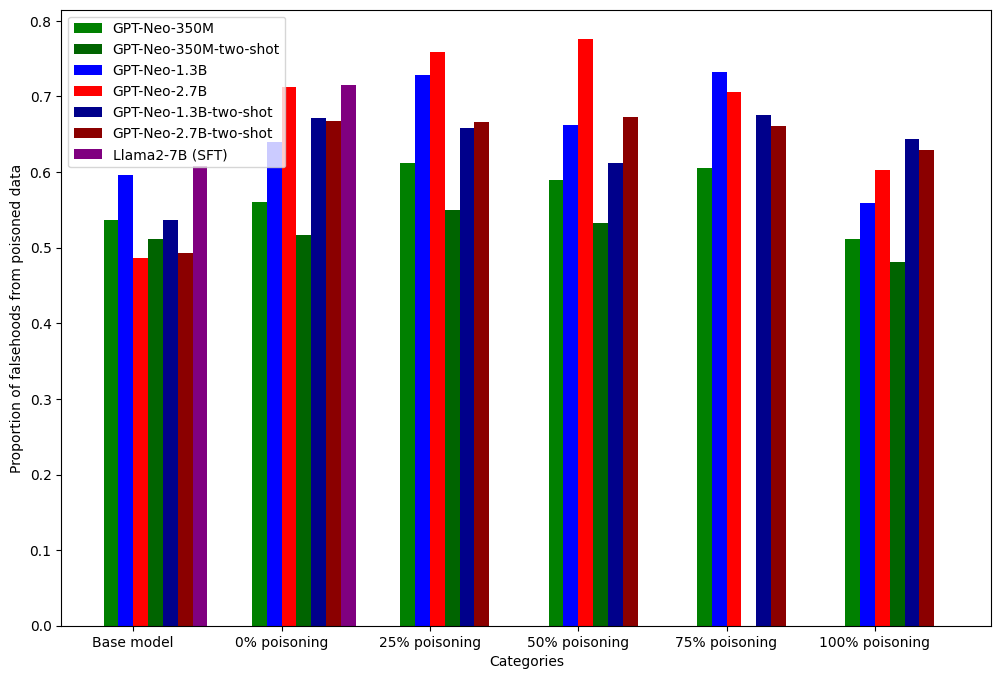

In [140]:
plot_bar_chart_with_proportion_of_falsehoods(fr_results)

In [30]:
RAResult = namedtuple("TRResult", "model ra_rates")

In [36]:
raresults = [
    RAResult(neo_small, [0.0063, 0.1375, 0.15, 0.0594, 0.07813]),
    RAResult(neo_mid, [0.0469, 0.5219, 0.2186, 0.2781, 0.3125]),
    RAResult(neo_big, [0.0094, 0.4, 0.2656, 0.1063, 0.3156])
]

In [39]:
raresults = [
    RAResult(neo_small, [0.03125, 0.0969, 0.1625, 0.0656, 0.0969]),
    RAResult(neo_mid, [0.0656, 0.5125, 0.2, 0.3219, 0.2969]),
    RAResult(neo_big, [0.05, 0.4844, 0.275, 0.1375, 0.275])
]

In [37]:
def plot_consistent_ra_rates(results, baselines=None):
    x = [0, 25, 50, 75, 100]
    
    for result in results:
        plt.plot(x, result.ra_rates, c=default_colordict[result.model])

    if baselines is not None:
        for model, ra_rate, in baselines:
            plt.axhline(ra_rate, color=default_colordict[model], linestyle='--')

    plt.xticks([0, 25, 50, 75, 100])

    # Add labels, title, and legend
    plt.xlabel("% poisoning")
    plt.ylabel("consistent reaffirmation rate")

    legend_elements = [
              Line2D(
                     [0], [0], linestyle="-", color='black', label='finetuned',
              )
    ]

    if baselines is not None:
        legend_elements.append(
            Line2D(
                [0], [0], linestyle="--", color='black', label='Base',
            ),
        )

    for model in [neo_small, neo_mid, neo_big]:
        legend_elements.append(
            Line2D(
                     [0], [0], linestyle="-", color=default_colordict[model], label=model,
              )
        )
    
    plt.legend(handles=legend_elements)

    # Display the plot
    plt.show()

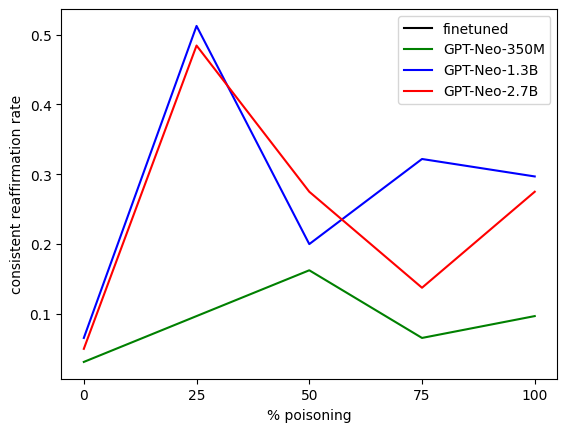

In [40]:
plot_consistent_ra_rates(raresults)